In [3]:
import random
import math
import pickle 
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
sigmoid_lambda=0.8
momentum=0.9
learning_rate=0.01
no_hidden_layer_nuerons=4

def sigmoid(x):
    
    #print(-1*x*sigmoid_lambda)
    sig=1/(1+math.exp(-1*x*sigmoid_lambda))
    return sig

def normalize_data(data):
    for i in range(len(data.iloc[0])):
        data[i]=(data[i]-min(data[i]))/(max(data[i])-min(data[i]))
    return data

def devide_train_test(data):
    tlen=int(len(data)*.70)
    train_data=data[:tlen]
    val_data=data[tlen:]
    val_data=val_data.reset_index(drop=True)
    return train_data,val_data

def shuffle_data(data):
    x=list(range(len(data)))
    random.shuffle(x)
    return data.iloc[x]


def save_model(model,file):
    file_name = open(file, 'wb')
    #with open('MLP.pkl', 'w') as file:
    pickle.dump(model, file_name, pickle.HIGHEST_PROTOCOL)
    
# def load_model():
#     #file = open('MLP.obj', 'r')
#     mlp=None
#     with open('MLP.pkl', 'r') as file:
#         mlp = pickle.load(file)
#     return mlp


class MLP:
    
    def __init__(self,input_size):
        self.input_size=input_size
        self.n_weight=[]    # list contaon no of input weights to each nueron
        self.n_weight.append(input_size)
        self.train_error=[]
        self.total_train_errors=[]
        self.train_MSE=[]
        self.total_val_errors=[]
        self.val_MSE=[]
        self.layers=[]
        self.output=[]
        
    def save_weights(self):
        model=self
        file_prefix_layer1="MLP_"
        for i in range(len(model.layers)):
            file_prefix_layer2=file_prefix_layer1+"Layer_"+str(i)+"_"
            for j in range(len(model.layers[i].nuerons)):
                file=file_prefix_layer2+"Nueron"+str(j)+"_Weights"
                #print(model.layers[i].nuerons[j].weights)
                save_model(model.layers[i].nuerons[j].weights,file)
    
    def load_weights(self):
        model=self
        file_prefix_layer1="MLP_"
        for i in range(len(model.layers)):
            file_prefix_layer2=file_prefix_layer1+"Layer_"+str(i)+"_"
            for j in range(len(model.layers[i].nuerons)):
                file=file_prefix_layer2+"Nueron"+str(j)+"_Weights"
                with open(file, 'rb') as filename:
                    model.layers[i].nuerons[j].weights = pickle.load(filename)
                
        
    def addLayer(self,total_nuerons,activation):
        layers_index=len(self.layers)
        L=Layer(self.n_weight[layers_index],total_nuerons,activation)
        self.layers.append(L)
        self.n_weight.append(total_nuerons)   # no of weights in next layer is going to equal to total_nuerons of current layer
    
    def calculate_MSE(self,error_list):
        sum_row=0
        for row in range(len(error_list)):
            sum_col=0
            for col in range(len(error_list[row])):
                sum_col = sum_col + error_list[row][col]*error_list[row][col]
            sum_row = sum_row+ sum_col/len(error_list[0])
        return sum_row/len(error_list)
    
    def train(self,input_x,input_y):
        self.predict(input_x)
        self.train_error=self.calculate_error(self.output,input_y)
        self.calculate_gradient_and_delta_w(input_x)
        self.update_weights()
    
    def predict(self,input_x):
        inp=input_x[:]
        for i in range(len(self.layers)):
            self.layers[i].calculate_output(inp)
            inp=self.layers[i].output
        self.output=self.layers[len(self.layers)-1].output 
        
    def calculate_error(self,modal_result,ground_truth):    
        return [ground_truth[i]-modal_result[i] for i in range(len(modal_result))]
    
    #being called by fit to show error
    def plot_error(self,epoch,train_error, val_error):
        
        plt.plot(epoch,train_error, 'b',label="Train Loss")
        
        if(len(val_error)!=0):
            plt.plot(epoch,val_error, 'r',label="Val Loss")
        plt.legend()
    
    
    #being called inside fit to show error
    def show_mse_error(self,train_MSE,epoch_no,val_MSE=[]):
        print("="*110)
        print("Epoch",(epoch_no+1),": ",end='')
        print("Train Error=",train_MSE[len(train_MSE)-1],end='')
        
        print(" "*30,end='')
        
        if(val_MSE != [] and len(val_MSE)!=0):
            print("Validation Error=",val_MSE[len(val_MSE)-1])
            
    
    #being called by user
    def fit(self,train_data,train_target,epoch=0,val_data=[],val_target=[]):
        
         
        if(not(isinstance(epoch,int)) or epoch==0):
            return "Please specify the no of epochs as your 3rd parameter inside fit mathod"
        
        self.train_MSE=[]
        self.val_MSE=[]
        self.total_train_errors=[]
        for epoch_no in range(epoch):
        
            for i in range(len(train_data)):
                x=list(train_data.iloc[i])
                y=list(train_target.iloc[i])            
                self.train(x,y)
                self.total_train_errors.append(self.train_error)

            temp_mse=self.calculate_MSE(self.total_train_errors)
            self.train_MSE.append(temp_mse)

            if(len(val_data) != 0 and len(val_target) != 0): 
                self.total_val_errors=[]
                for i in range(len(val_data)):
                    x=list(val_data.iloc[i])
                    y=list(val_target.iloc[i])
                    self.predict(x)
                    self.total_val_errors.append(self.calculate_error(self.output,y))

                temp_mse=self.calculate_MSE(self.total_val_errors)
                self.val_MSE.append(temp_mse)

            self.show_mse_error(self.train_MSE,epoch_no,self.val_MSE)
            
            #shuffle train_data and target indexes after each epoch to make it more robust       
            x=list(range(len(train_data)))
            random.shuffle(x)
            train_data=train_data.iloc[x]
            train_target=train_target.iloc[x]
            ######################################
            
        self.plot_error(range(len(self.train_MSE)),self.train_MSE,self.val_MSE)
               
    
    def update_weights(self):
        
        for layer in self.layers:
            for nueron in layer.nuerons:
                for k in range(len(nueron.weights)):
                    nueron.weights[k]=nueron.weights[k]+nueron.delta_weights[k]
    
    def calculate_gradient_and_delta_w(self,input_x):
    
        Layer2_delta_weights=[]
        grade_mul_weights=[]


        no_of_layers=len(self.layers)
        i=1
        while(no_of_layers-i>=0):

            if(i==1):    # handle last layer differently

                last = no_of_layers-i
                nuerons=self.layers[last].nuerons
                for j in range(len(nuerons)):
                    nuerons[j].grad=1*self.train_error[j]

                    #print("Grad=",nuerons[j].grad)
                    
                    #calculating deta w for last layer  Hk*Grad*Learning_Rate
                    delta=[]
                    for k in range(len(nuerons[j].weights)-1):                 #run for number of nuerons= len(weights)-1 bcs last weight belong to bias
                        delta.append(self.layers[last-1].output[k] * nuerons[j].grad * learning_rate + momentum*nuerons[j].delta_weights[k])  #k is representing kth nueron of last. weights[k] is weight coming from kth nueron of last layer
                    
                    last_weight_index=len(nuerons[j].weights)-1
                    delta.append(nuerons[j].grad*learning_rate + momentum*nuerons[j].delta_weights[last_weight_index])
                    nuerons[j].delta_weights=delta
                    
            else:
                
                
                #print("Hindden Layer")
                
                output=[]
                if(no_of_layers-i==0):
                    output=input_x[:]
                else:
                    output=self.layers[last-1].output[k]
                
                current = no_of_layers-i
                nuerons_h=self.layers[current].nuerons            # nuerons_h is current layer
                for j in range(len(nuerons_h)):
                    nuerons_hx1 =self.layers[current+1].nuerons   #nuerons_hx1 is next layer
                    summ=0
#                    str1=""
                    for k in range(len(nuerons_hx1)):
                        summ = summ+(nuerons_hx1[k].weights[j]*nuerons_hx1[k].grad)   #j is representing current hidden layer nuron index. weights[j] means weight coming jth nueron of current layer
                        
                        
#                         str1=str1+str(nuerons_hx1[k].weights[j])+"*"+str(nuerons_hx1[k].grad)+"+"
#                     str1=str1+str(nuerons_h[j].Hk)+"*"+str(1-nuerons_h[j].Hk)
#                     print(str1)
                    
                    nuerons_h[j].grad=summ*nuerons_h[j].Hk*(1-nuerons_h[j].Hk)*learning_rate
                    
                    delta=[]
                    
                    for k in range(len(nuerons_h[j].weights)-1):                 #run for number of nuerons= len(weights)-1 bcs last weight belong to bias
                        delta.append(output[k]*nuerons_h[j].grad*learning_rate + momentum*nuerons_h[j].delta_weights[k])
                    
                    last_weight_index=len(nuerons_h[j].weights)-1      # this index corresponds to bias
    
                    delta.append(nuerons_h[j].grad*learning_rate + momentum*nuerons_h[j].delta_weights[last_weight_index])
                    nuerons_h[j].delta_weights=delta
                            
                    
            i=i+1
            
            
        


            
class Layer:    
    def __init__(self,input_size,total_nuerons,activation):
        self.output=[]
        self.activation=activation
        self.nuerons=[Nueron(input_size) for i in range(total_nuerons)]        
    def calculate_output(self,input_x):
        self.output=[]
        for i in range(len(self.nuerons)):
            self.nuerons[i].calculate_output(input_x,self.activation)
            self.output.append(self.nuerons[i].Hk)  
            
class Nueron:
    def __init__(self,input_size):
        self.weights=[random.random() for i in range(input_size+1)]  #input_size  + 1(weight for bias)
        self.delta_weights=[0]*(input_size+1)
        self.Vk=None
        self.Hk=None
        self.grad=None
        
    def calculate_output(self,input_x,activation):          
        self.Vk=sum([self.weights[i]*input_x[i] for i in range(len(input_x))]) + self.weights[len(input_x)]
        if(activation=='linear'):
            self.Hk=self.Vk
        if(activation=='sigmoid'): 
            self.Hk=sigmoid(self.Vk)        

In [5]:
#read and preprocess data
data=pd.read_csv("game.csv",header = None)
data=shuffle_data(data)

TD,VD = devide_train_test(data)

TX=TD[[0,1]]
TX=normalize_data(TX)
TY=TD[[2,3]]

VX=VD[[0,1]]
VX=normalize_data(VX)
VY=VD[[2,3]]

<ipython-input-4-10ee12873d7b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i]=(data[i]-min(data[i]))/(max(data[i])-min(data[i]))


In [7]:
#model parameters
sigmoid_lambda=0.8
momentum=0.1
learning_rate=0.001
no_hidden_layer_nuerons=5

In [8]:
#create model architecture
model=MLP(2)
model.addLayer(no_hidden_layer_nuerons,'sigmoid')
model.addLayer(2,'linear')

Epoch 1 : Train Error= 2.789200560121077                              Validation Error= 2.8111563788868192
Epoch 2 : Train Error= 2.770941808806162                              Validation Error= 2.7955619059057404
Epoch 3 : Train Error= 2.757702793856417                              Validation Error= 2.7720656188834347
Epoch 4 : Train Error= 2.7465796908251816                              Validation Error= 2.757949893837872
Epoch 5 : Train Error= 2.736260358374687                              Validation Error= 2.734874265524298
Epoch 6 : Train Error= 2.7263438122910917                              Validation Error= 2.717513390075734
Epoch 7 : Train Error= 2.7169185478319293                              Validation Error= 2.702590349076725
Epoch 8 : Train Error= 2.70791262088426                              Validation Error= 2.6885999934146834
Epoch 9 : Train Error= 2.6993573388445355                              Validation Error= 2.673514181605656
Epoch 10 : Train Error= 2.6911256566180

Epoch 39 : Train Error= 2.531100543263799                              Validation Error= 2.4414281964179483
Epoch 40 : Train Error= 2.5273059967930274                              Validation Error= 2.432073163790511
Epoch 41 : Train Error= 2.5235895629132044                              Validation Error= 2.482764247249157
Epoch 42 : Train Error= 2.51994767533588                              Validation Error= 2.414535195067842
Epoch 43 : Train Error= 2.5163919728434045                              Validation Error= 2.411022679903401
Epoch 44 : Train Error= 2.512924550795832                              Validation Error= 2.412161750382218
Epoch 45 : Train Error= 2.509531207367766                              Validation Error= 2.4019545840261927
Epoch 46 : Train Error= 2.5062170742215053                              Validation Error= 2.4066613516447557
Epoch 47 : Train Error= 2.502975622575327                              Validation Error= 2.416457886239949
Epoch 48 : Train Error= 2.49983

Epoch 77 : Train Error= 2.43569985901311                              Validation Error= 2.403288052815929
Epoch 78 : Train Error= 2.4342199894115373                              Validation Error= 2.391411987956384
Epoch 79 : Train Error= 2.432778789106317                              Validation Error= 2.358602789596631
Epoch 80 : Train Error= 2.431364817388538                              Validation Error= 2.3599609367786503
Epoch 81 : Train Error= 2.4299843697147976                              Validation Error= 2.36248876449514
Epoch 82 : Train Error= 2.428642336697594                              Validation Error= 2.3576667721471716
Epoch 83 : Train Error= 2.4273261254487815                              Validation Error= 2.361816190005453
Epoch 84 : Train Error= 2.4260449434060662                              Validation Error= 2.371820215836913
Epoch 85 : Train Error= 2.4247880003100866                              Validation Error= 2.3579373051586265
Epoch 86 : Train Error= 2.42355

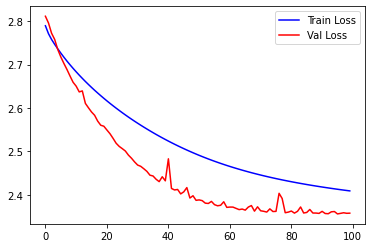

In [9]:
model.fit(TX,TY,100,VX,VY)

In [34]:
#model parameters
sigmoid_lambda=0.8
momentum=0.9
learning_rate=0.8
no_hidden_layer_nuerons=5

Epoch 1 : Train Error= 3.621330560318747                              Validation Error= 2.445486062318653
Epoch 2 : Train Error= 3.599366816920823                              Validation Error= 2.4403941914241556
Epoch 3 : Train Error= 3.5919776279537095                              Validation Error= 2.439735230488178
Epoch 4 : Train Error= 3.588298602092487                              Validation Error= 2.4399664552108433
Epoch 5 : Train Error= 3.5860876843546294                              Validation Error= 2.440222028615889
Epoch 6 : Train Error= 3.5846111950807718                              Validation Error= 2.4404305580688597
Epoch 7 : Train Error= 3.5835551698644474                              Validation Error= 2.440598016619786
Epoch 8 : Train Error= 3.5827623473547763                              Validation Error= 2.4407341392241864
Epoch 9 : Train Error= 3.5821452081770904                              Validation Error= 2.4408462227946077
Epoch 10 : Train Error= 3.581651169

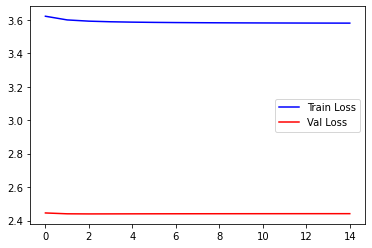

In [43]:
#model parameters
sigmoid_lambda=0.8
momentum=0.9
learning_rate=0.1
no_hidden_layer_nuerons=5

#create model architecture
model2=MLP(2)
model2.addLayer(no_hidden_layer_nuerons,'sigmoid')
model2.addLayer(2,'linear')
model2.fit(TX,TY,15,VX,VY)

Epoch 1 : Train Error= 5.126496254439067                              Validation Error= 4.0299036017005445
Epoch 2 : Train Error= 5.134982380753118                              Validation Error= 4.066526332509173
Epoch 3 : Train Error= 5.137631470806148                              Validation Error= 4.071864734092582
Epoch 4 : Train Error= 5.13708596893762                              Validation Error= 4.069451646245883
Epoch 5 : Train Error= 5.139183646906978                              Validation Error= 4.071935715004135
Epoch 6 : Train Error= 5.140832599255244                              Validation Error= 4.0710362878066295
Epoch 7 : Train Error= 5.141615212702943                              Validation Error= 4.0719304627422686
Epoch 8 : Train Error= 5.14267938932765                              Validation Error= 4.071925824344956
Epoch 9 : Train Error= 5.143506407144362                              Validation Error= 4.071921881271016
Epoch 10 : Train Error= 5.144167407814793    

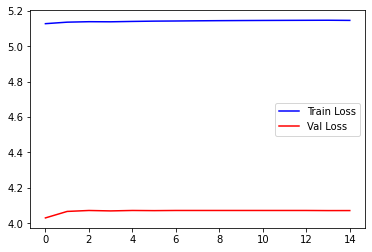

In [45]:
#model parameters
sigmoid_lambda=0.8
momentum=0.1
learning_rate=0.9
no_hidden_layer_nuerons=5

#create model architecture
model2=MLP(2)
model2.addLayer(no_hidden_layer_nuerons,'sigmoid')
model2.addLayer(2,'linear')
model2.fit(TX,TY,15,VX,VY)

Epoch 1 : Train Error= 4.713632651080957                              Validation Error= 3.844682068223101
Epoch 2 : Train Error= 4.718188406768712                              Validation Error= 3.8176951414009896
Epoch 3 : Train Error= 4.713374907818687                              Validation Error= 3.8293494414322637
Epoch 4 : Train Error= 4.693980804796028                              Validation Error= 3.8257592378977625
Epoch 5 : Train Error= 4.685578121093554                              Validation Error= 3.704513360758448
Epoch 6 : Train Error= 4.681270729365399                              Validation Error= 3.8346509451629904
Epoch 7 : Train Error= 4.680227503432603                              Validation Error= 3.9339187396481305
Epoch 8 : Train Error= 4.675466133247676                              Validation Error= 3.9490018452262565
Epoch 9 : Train Error= 4.6702623806033206                              Validation Error= 3.837312563925546
Epoch 10 : Train Error= 4.6670749443370

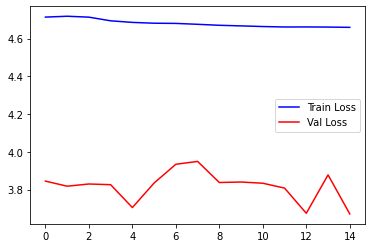

In [51]:
#model parameters
sigmoid_lambda=0.8
momentum=0.1
learning_rate=0.8
no_hidden_layer_nuerons=2

#create model architecture
model2=MLP(2)
model2.addLayer(no_hidden_layer_nuerons,'sigmoid')
model2.addLayer(2,'linear')
model2.fit(TX,TY,15,VX,VY)

Epoch 1 : Train Error= 4.721620208081743                              Validation Error= 3.8455053987248005
Epoch 2 : Train Error= 4.723042007791531                              Validation Error= 3.8451962327647204
Epoch 3 : Train Error= 4.724360686984463                              Validation Error= 3.844952698337324
Epoch 4 : Train Error= 4.724261642294675                              Validation Error= 3.844966047914285
Epoch 5 : Train Error= 4.7254661974368135                              Validation Error= 3.846168232651965
Epoch 6 : Train Error= 4.72627846110941                              Validation Error= 3.8459790441404174
Epoch 7 : Train Error= 4.726527628023023                              Validation Error= 3.8399701889591484
Epoch 8 : Train Error= 4.727042430740688                              Validation Error= 3.84619833009361
Epoch 9 : Train Error= 4.726905706336812                              Validation Error= 3.8412467376694344
Epoch 10 : Train Error= 4.726926026967073 

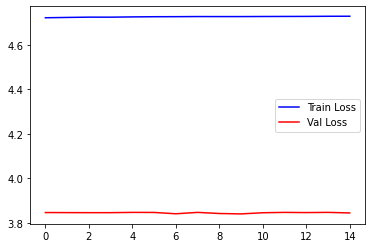

In [52]:
#model parameters
sigmoid_lambda=0.8
momentum=0.1
learning_rate=0.8
no_hidden_layer_nuerons=3

#create model architecture
model2=MLP(2)
model2.addLayer(no_hidden_layer_nuerons,'sigmoid')
model2.addLayer(2,'linear')
model2.fit(TX,TY,15,VX,VY)

Epoch 1 : Train Error= 2.5036404556123566                              Validation Error= 2.425035510257617
Epoch 2 : Train Error= 2.457324052318971                              Validation Error= 2.411300647789425
Epoch 3 : Train Error= 2.440350577723984                              Validation Error= 2.4065702037697454
Epoch 4 : Train Error= 2.430881686559975                              Validation Error= 2.4031400155590315
Epoch 5 : Train Error= 2.424139947208168                              Validation Error= 2.4001743268223974
Epoch 6 : Train Error= 2.4186042135320625                              Validation Error= 2.397551594642144
Epoch 7 : Train Error= 2.4138094263755288                              Validation Error= 2.395438149473298
Epoch 8 : Train Error= 2.4096155593732003                              Validation Error= 2.393925208012954
Epoch 9 : Train Error= 2.405948517375222                              Validation Error= 2.392919854823493
Epoch 10 : Train Error= 2.4027410441155

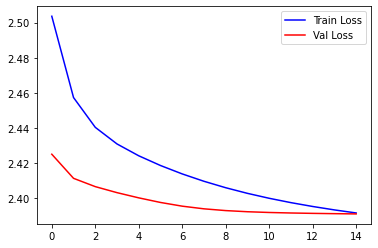

In [53]:
#model parameters
sigmoid_lambda=0.8
momentum=0.1
learning_rate=0.1
no_hidden_layer_nuerons=3

#create model architecture
model2=MLP(2)
model2.addLayer(no_hidden_layer_nuerons,'sigmoid')
model2.addLayer(2,'linear')
model2.fit(TX,TY,15,VX,VY)

Epoch 1 : Train Error= 2.6350749257958137                              Validation Error= 2.4900764151045025
Epoch 2 : Train Error= 2.5998301858186736                              Validation Error= 2.454527001793418
Epoch 3 : Train Error= 2.5842007972645757                              Validation Error= 2.4362199716430144
Epoch 4 : Train Error= 2.5714231416354982                              Validation Error= 2.425795116428764
Epoch 5 : Train Error= 2.562700285547437                              Validation Error= 2.4206582208766587
Epoch 6 : Train Error= 2.5564610104860868                              Validation Error= 2.4173492676607324
Epoch 7 : Train Error= 2.5517387560570013                              Validation Error= 2.4156581703630478
Epoch 8 : Train Error= 2.548012466376849                              Validation Error= 2.4149223080181788
Epoch 9 : Train Error= 2.54499910038229                              Validation Error= 2.413790613167497
Epoch 10 : Train Error= 2.542530758

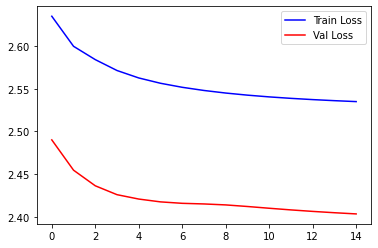

In [54]:
#model parameters
sigmoid_lambda=0.8
momentum=0.1
learning_rate=0.2
no_hidden_layer_nuerons=4

#create model architecture
model2=MLP(2)
model2.addLayer(no_hidden_layer_nuerons,'sigmoid')
model2.addLayer(2,'linear')
model2.fit(TX,TY,15,VX,VY)

Epoch 1 : Train Error= 2.880045943274204                              Validation Error= 2.566770151518198
Epoch 2 : Train Error= 2.8619116246173477                              Validation Error= 2.5353107220716806
Epoch 3 : Train Error= 2.854997161172389                              Validation Error= 2.5291599589678047
Epoch 4 : Train Error= 2.8513322583343257                              Validation Error= 2.529087052586655
Epoch 5 : Train Error= 2.8490586930438377                              Validation Error= 2.530516954145769
Epoch 6 : Train Error= 2.847597780096616                              Validation Error= 2.5307804285365085
Epoch 7 : Train Error= 2.8465978923332003                              Validation Error= 2.530767549007179
Epoch 8 : Train Error= 2.8458680766739866                              Validation Error= 2.5307806463110816
Epoch 9 : Train Error= 2.845310548749704                              Validation Error= 2.5308257955662112
Epoch 10 : Train Error= 2.8448703331

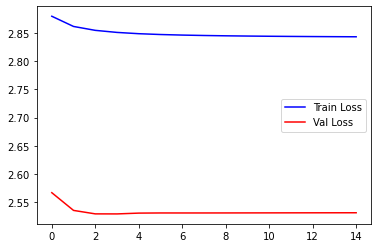

In [55]:
#model parameters
sigmoid_lambda=0.8
momentum=0.2
learning_rate=0.3
no_hidden_layer_nuerons=4

#create model architecture
model2=MLP(2)
model2.addLayer(no_hidden_layer_nuerons,'sigmoid')
model2.addLayer(2,'linear')
model2.fit(TX,TY,15,VX,VY)

Epoch 1 : Train Error= 2.7931172234145136                              Validation Error= 2.698617823262607
Epoch 2 : Train Error= 2.7409967347836526                              Validation Error= 2.5969834459574437
Epoch 3 : Train Error= 2.679827655823804                              Validation Error= 2.439822310351203
Epoch 4 : Train Error= 2.6103842296950606                              Validation Error= 2.3315834935869812
Epoch 5 : Train Error= 2.558515301514254                              Validation Error= 2.3202273873903936
Epoch 6 : Train Error= 2.52309500671741                              Validation Error= 2.3185203982442117
Epoch 7 : Train Error= 2.49753944718264                              Validation Error= 2.3170049611340215
Epoch 8 : Train Error= 2.478167433377052                              Validation Error= 2.3153777151343693
Epoch 9 : Train Error= 2.46291393428708                              Validation Error= 2.313670832875304
Epoch 10 : Train Error= 2.45053894418413

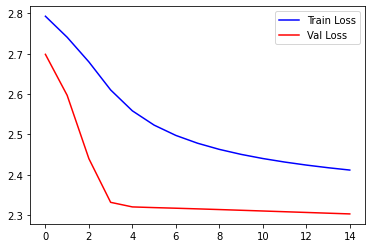

In [59]:
#model parameters
sigmoid_lambda=0.8
momentum=0.1
learning_rate=0.01
no_hidden_layer_nuerons=3

#create model architecture
model2=MLP(2)
model2.addLayer(no_hidden_layer_nuerons,'sigmoid')
model2.addLayer(2,'linear')
model2.fit(TX,TY,15,VX,VY)

Epoch 1 : Train Error= 2.680175022019398                              Validation Error= 2.5017272963405874
Epoch 2 : Train Error= 2.593621454105006                              Validation Error= 2.4506452529802334
Epoch 3 : Train Error= 2.550405307858314                              Validation Error= 2.398019822177511
Epoch 4 : Train Error= 2.5191091647611636                              Validation Error= 2.3660736733372696
Epoch 5 : Train Error= 2.495781256108069                              Validation Error= 2.347986965532397
Epoch 6 : Train Error= 2.47787282680556                              Validation Error= 2.3369513517915865
Epoch 7 : Train Error= 2.4638242885207022                              Validation Error= 2.3305505398486197
Epoch 8 : Train Error= 2.452654449908594                              Validation Error= 2.3269766934652405
Epoch 9 : Train Error= 2.4436568103240868                              Validation Error= 2.324848289409155
Epoch 10 : Train Error= 2.436300009658

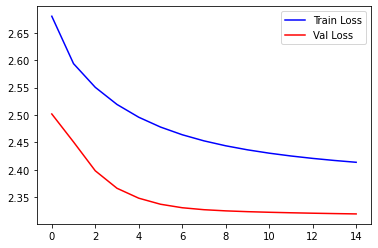

In [60]:
#model parameters
sigmoid_lambda=0.8
momentum=0.9
learning_rate=0.01
no_hidden_layer_nuerons=3

#create model architecture
model2=MLP(2)
model2.addLayer(no_hidden_layer_nuerons,'sigmoid')
model2.addLayer(2,'linear')
model2.fit(TX,TY,15,VX,VY)

In [70]:
#model parameters
sigmoid_lambda=0.8
momentum=0.9
learning_rate=0.01
no_hidden_layer_nuerons=4

#create model architecture
model2=MLP(2)
model2.addLayer(no_hidden_layer_nuerons,'sigmoid')
model2.addLayer(2,'linear')
model2.fit(TX,TY,200,VX,VY)

Epoch 1 : Train Error= 2.6861314975545585                              Validation Error= 2.521957867879645
Epoch 2 : Train Error= 2.604815818889004                              Validation Error= 2.466875794493524
Epoch 3 : Train Error= 2.5645039726340864                              Validation Error= 2.422755102645935
Epoch 4 : Train Error= 2.5341778319203634                              Validation Error= 2.3813127853716525
Epoch 5 : Train Error= 2.5094278513527977                              Validation Error= 2.354716001186151
Epoch 6 : Train Error= 2.489677866428117                              Validation Error= 2.3400466635803463
Epoch 7 : Train Error= 2.474072150634625                              Validation Error= 2.332146878214629
Epoch 8 : Train Error= 2.4616808075719545                              Validation Error= 2.327691051461277
Epoch 9 : Train Error= 2.451712769630317                              Validation Error= 2.3249304685220253
Epoch 10 : Train Error= 2.443564823649

Epoch 39 : Train Error= 2.3854300965410142                              Validation Error= 2.311744963664072
Epoch 40 : Train Error= 2.384885686781995                              Validation Error= 2.311586226903354
Epoch 41 : Train Error= 2.3843663618752147                              Validation Error= 2.311432424718334
Epoch 42 : Train Error= 2.383870386591862                              Validation Error= 2.3112833747653068
Epoch 43 : Train Error= 2.383396183932399                              Validation Error= 2.3111389028092724
Epoch 44 : Train Error= 2.3829423173842605                              Validation Error= 2.310998842060617
Epoch 45 : Train Error= 2.3825074755238584                              Validation Error= 2.310863032675195
Epoch 46 : Train Error= 2.382090458608329                              Validation Error= 2.310731321365081
Epoch 47 : Train Error= 2.381690166862956                              Validation Error= 2.3106035610832243
Epoch 48 : Train Error= 2.3813

Epoch 77 : Train Error= 2.374306504302435                              Validation Error= 2.308074066606121
Epoch 78 : Train Error= 2.3741531670404044                              Validation Error= 2.3080202448534415
Epoch 79 : Train Error= 2.374003476567431                              Validation Error= 2.307967782193111
Epoch 80 : Train Error= 2.3738573018555877                              Validation Error= 2.3079166370963575
Epoch 81 : Train Error= 2.3737145181540895                              Validation Error= 2.3078667694443404
Epoch 82 : Train Error= 2.373575006612601                              Validation Error= 2.307818140482767
Epoch 83 : Train Error= 2.37343865393161                              Validation Error= 2.307770712778209
Epoch 84 : Train Error= 2.3733053520378684                              Validation Error= 2.307724450176753
Epoch 85 : Train Error= 2.373174997781617                              Validation Error= 2.307679317764039
Epoch 86 : Train Error= 2.37304

KeyboardInterrupt: 

Epoch 1 : Train Error= 2.706626690808007                              Validation Error= 2.3852264924443785
Epoch 2 : Train Error= 2.6049838983340305                              Validation Error= 2.4245572237300967
Epoch 3 : Train Error= 2.556827026530469                              Validation Error= 2.293980201042034
Epoch 4 : Train Error= 2.5219299983497865                              Validation Error= 2.349676323195149
Epoch 5 : Train Error= 2.4967001304776644                              Validation Error= 2.3249163709384075
Epoch 6 : Train Error= 2.477653702511909                              Validation Error= 2.2543191924155788
Epoch 7 : Train Error= 2.462564867860612                              Validation Error= 2.2533659672685573
Epoch 8 : Train Error= 2.4517351021120417                              Validation Error= 2.3224915749385673
Epoch 9 : Train Error= 2.4428299984671327                              Validation Error= 2.301818697203917
Epoch 10 : Train Error= 2.435028396

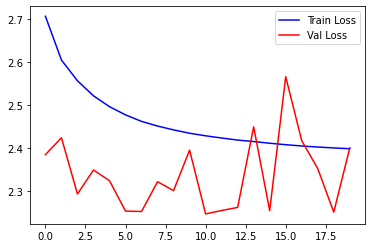

In [23]:
#model parameters
sigmoid_lambda=0.8
momentum=0.9
learning_rate=0.01
no_hidden_layer_nuerons=5

#create model architecture
model2=MLP(2)
model2.addLayer(no_hidden_layer_nuerons,'sigmoid')
model2.addLayer(2,'linear')
model2.fit(TX,TY,20,VX,VY)

In [22]:
model=model2
file_prefix_layer1="MLP_"
for i in range(len(model.layers)):
    file_prefix_layer2=file_prefix_layer1+"Layer_"+str(i)+"_"
    for j in range(len(model.layers[i].nuerons)):
        file=file_prefix_layer2+"Nueron"+str(j)+"_Weights"
        #print(model.layers[i].nuerons[j].weights)
        save_model(model.layers[i].nuerons[j].weights,file)
        
    

#save_model(model2.layers[0].nuerons[0].weights)

In [11]:
sigmoid_lambda=0.8
momentum=0.9
learning_rate=0.01
no_hidden_layer_nuerons=5

#create model architecture
model2=MLP(2)
model2.addLayer(no_hidden_layer_nuerons,'sigmoid')
model2.addLayer(2,'linear')

In [13]:
model2=MLP(2)
model2.addLayer(no_hidden_layer_nuerons,'sigmoid')
model2.addLayer(2,'linear')



import time

model=self
mlp=[]
for i in range(len(model.layers)):
    layers=[]
    for j in range(len(model.layers[i].nuerons)):
        layers.append(model.layers[i].nuerons[j].weights)
    mlp.append(layers)
time_stamp=int(time.time())
save_model(mlp,'model_weights_'+str(time_stamp))

In [26]:
len(mlp)
len(mlp[0][0])

3

In [29]:
def save_model(model,file):
    file_name = open(file, 'wb')
    pickle.dump(model, file_name, pickle.HIGHEST_PROTOCOL)

In [40]:
    def save_weights_and_params(self,params):
        model=model2
        mlp=[]
        for i in range(len(model.layers)):
            layers=[]
            for j in range(len(model.layers[i].nuerons)):
                layers.append(model.layers[i].nuerons[j].weights)
            mlp.append(layers)
        time_stamp=int(time.time())
        save_model(mlp,'model_weights_'+str(time_stamp))
        
        
    def load_weights(self):
        with open('model_weights_', 'rb') as filename:
            mlp=pickle.load(filename)
            model=model2
            for i in range(len(mlp)):
                for j in range(len(mlp[i])):
                    model.layers[i].nuerons[j].weights = mlp[i][j]
            return mlp

In [36]:
def load_weights(self):
    with open('model_weights_', 'rb') as filename:
        mlp=pickle.load(filename)
        model=model2
        for i in range(len(mlp)):
            for j in range(len(mlp[i])):
                model.layers[i].nuerons[j].weights = mlp[i][j]
        return mlp

In [41]:
save_weights_and_params(mlp,'')

In [44]:
mlp

[[[0.2743435696095522, 0.22171772489022212, 0.9814225126500645],
  [0.03810118220016734, 0.7778803820327432, 0.5371255621635027],
  [0.8775226238737801, 0.902962391459522, 0.8577249482834498],
  [0.9249602578676837, 0.5766363141383569, 0.3360179577408928],
  [0.8189019059367623, 0.010912636274587273, 0.3456573254264954]],
 [[0.5618010978099717,
   0.6504870798731593,
   0.12615128417220578,
   0.947961039975591,
   0.60902815714594,
   0.4338677899810274],
  [0.27302205154076753,
   0.602548679217418,
   0.6498173761094187,
   0.09146074487504363,
   0.27814204398478437,
   0.9616353656855368]]]

In [42]:
mlp222=load_weights(model2)

In [43]:
mlp222

[[[0.2743435696095522, 0.22171772489022212, 0.9814225126500645],
  [0.03810118220016734, 0.7778803820327432, 0.5371255621635027],
  [0.8775226238737801, 0.902962391459522, 0.8577249482834498],
  [0.9249602578676837, 0.5766363141383569, 0.3360179577408928],
  [0.8189019059367623, 0.010912636274587273, 0.3456573254264954]],
 [[0.5618010978099717,
   0.6504870798731593,
   0.12615128417220578,
   0.947961039975591,
   0.60902815714594,
   0.4338677899810274],
  [0.27302205154076753,
   0.602548679217418,
   0.6498173761094187,
   0.09146074487504363,
   0.27814204398478437,
   0.9616353656855368]]]